# Task 3: Forecasting Brent Oil Prices

In this notebook, we will develop a forecasting model for Brent oil prices. This involves:
1. Checking for stationarity in the time series data.
2. Preparing the data for model training and testing.
3. Building a time series forecasting model, starting with ARIMA.

In [ ]:
# Import necessary libraries
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
from statsmodels.tsa.arima.model import ARIMA
import warnings
# from pmdarima import auto_arima
os.chdir(r'c:\users\ermias.tadesse\10x\Oil-Price-Insights')  # Set the working directory to the project root
# Load the Brent Oil Prices dataset
file_path = 'Data/Raw/BrentOilPrices.csv'

# Load the Brent Oil Prices dataset
# data = pd.read_csv('../Data/BrentOilPrice.csv', index_col='Date', parse_dates=True)
data = pd.read_csv(file_path)
data = data[['Price']].dropna()


In [8]:
# Perform the ADF test for stationarity
result = adfuller(data['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation of the result
if result[1] > 0.05:
    print("The data is likely non-stationary. Consider differencing for stationary models.")
else:
    print("The data is likely stationary.")


ADF Statistic: -1.993856011392467
p-value: 0.2892735048934032
The data is likely non-stationary. Consider differencing for stationary models.


In [9]:
# Split data into train and test sets (e.g., 80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f"Training data points: {len(train)}, Testing data points: {len(test)}")


Training data points: 7208, Testing data points: 1803


### Step 3: Building the ARIMA Model

We will build an ARIMA model for forecasting Brent oil prices. The steps include:
1. Using auto_arima to find the best (p, d, q) parameters.
2. Fitting the ARIMA model with the training data.
3. Forecasting and evaluating the model performance on the test data.


In [10]:


# Define the range of p, d, q values to try
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

# Grid search to find the best parameters
best_aic = float("inf")
best_order = None
best_model = None

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")


Best ARIMA order: (2, 1, 3) with AIC: 21254.375910704497


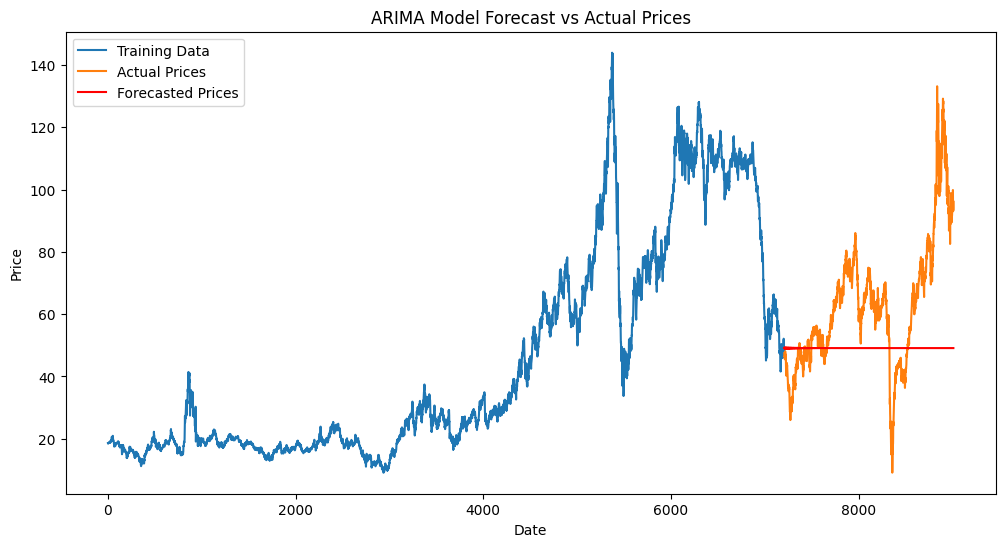

In [11]:
# Use the best order found from the grid search
p, d, q = best_order
arima_model = ARIMA(train, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Forecast the test set
forecast = arima_model_fit.forecast(steps=len(test))
forecast.index = test.index

# Plotting the forecast against actual prices
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Prices')
plt.plot(forecast, label='Forecasted Prices', color='red')
plt.title("ARIMA Model Forecast vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [12]:
# Evaluate the model's performance
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 613.4690649804356
Mean Absolute Error: 18.430844823559184


### Step 4: Residual Diagnostics and Baseline Comparison

We will:
1. Analyze residuals to ensure that they are randomly distributed (indicating a good model fit).
2. Compare our ARIMA model with a simple baseline model to see if it adds value over a naive forecast.

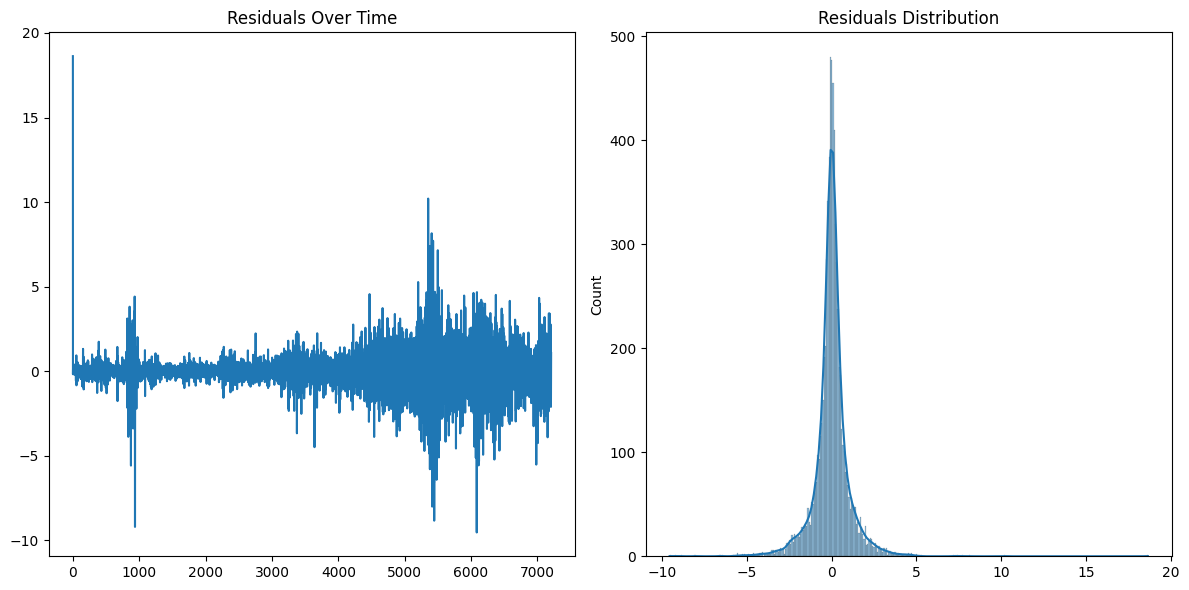

Normality test p-value: 0.0
Residuals may not be normally distributed.


In [13]:
import seaborn as sns
import scipy.stats as stats

# Plot residuals
residuals = arima_model_fit.resid

plt.figure(figsize=(12, 6))

# Plot residuals over time
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title("Residuals Over Time")

# Plot residuals histogram
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")

plt.tight_layout()
plt.show()

# Conduct normality test on residuals
k2, p = stats.normaltest(residuals)
print(f"Normality test p-value: {p}")

if p > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals may not be normally distributed.")


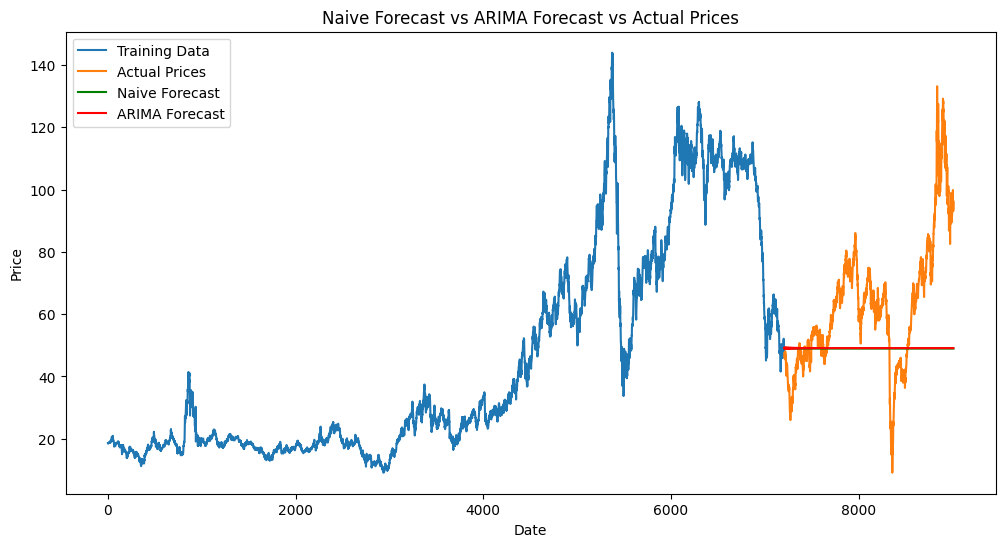

Naive Forecast - Mean Squared Error: 617.7846169717137
Naive Forecast - Mean Absolute Error: 18.501763727121464

Comparison with ARIMA Model:
ARIMA MSE: 613.4690649804356, Naive MSE: 617.7846169717137
ARIMA MAE: 18.430844823559184, Naive MAE: 18.501763727121464


In [14]:
# Naive forecast: Use the last value of the training set as the forecast for all test points
naive_forecast = [train.iloc[-1]] * len(test)

# Plot naive forecast against actual prices
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Prices')
plt.plot(test.index, naive_forecast, label='Naive Forecast', color='green')
plt.plot(forecast, label='ARIMA Forecast', color='red')
plt.title("Naive Forecast vs ARIMA Forecast vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Calculate performance metrics for naive forecast
naive_mse = mean_squared_error(test, naive_forecast)
naive_mae = mean_absolute_error(test, naive_forecast)
print(f"Naive Forecast - Mean Squared Error: {naive_mse}")
print(f"Naive Forecast - Mean Absolute Error: {naive_mae}")

# Compare ARIMA and Naive Model
print("\nComparison with ARIMA Model:")
print(f"ARIMA MSE: {mse}, Naive MSE: {naive_mse}")
print(f"ARIMA MAE: {mae}, Naive MAE: {naive_mae}")